## EWA Python Implementation

The code that follows is for the implementation of a basic EWA model for a bi-matrix game structure. 

In [7]:
# Imports (requirements)
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [8]:
# SOLUTION CONCEPT

# We need to find the parameter values that reduces the distance from the predicted 
# probabilities to the real probabilities

# REAL PROBABILITIES 
real_prob_p1s1 = 0.461
real_prob_p2s1 =  0.136

# objective function Q (we need to minimize with the parameter fitting)
# Q = sqrt((prediction p1 - real p1)^2 + (prediction p2 - real p2)^2)

# Example predicted probabilities
prob_p1s1 = 0.534
prob_p2s1 = 0.299


Q = np.sqrt(((prob_p1s1 - real_prob_p1s1) ** 2 + (prob_p2s1 - real_prob_p2s1) ** 2))
Q

0.17860011198204775

In [2]:
# Experience-Weighted Attraction - Model Tuning

# EWA Models' parameters
rho = 0.97 # Depreciation rate of past experience (should usually be slightly less than 1)
delta = 0.60 # Weight added for used versus unused strategies
phi = 0.94 # Second discount rate for past experience (can be different than rho)
lam = 0.80 # Sensitivity to attractions

# Initial attractions (A) - 2x2
A_0_p1s1 = 1 # Player 1's Initial attraction to strategy 1
A_0_p1s2 = 0 # Player 1's initial attraction to strategy 2
A_0_p2s1 = -2 # Player 2's Initial attraction to strategy 1
A_0_p2s2 = 0 # Player 2's Initial attraction to strategy 2

# Initial experience (N)
N_0 = 1

# Rounds
n_sims = 50 # epochs (outer loop)
n_periods = 1000 # rounds within epochs (inner loop)

#TO BE SOLVED
real_prob_p1s1 = 0.5
real_prob_p2s1 = 0.5


The initial parameters of the model must be estimated and defined according to the simulation targets, as per the overview provided in **1.5**. Additionally, the number of simulation rounds and periods can be defined according to the practitioner's choice.

In [3]:
# Game Structure Definitions (2x2)

# Defining the matrix game in a vector-like structure
p1_payoffs = [1, 0, 0, 2] # p1's (ROW) payoffs in a bi-matrix arrangement
p2_payoffs = [-1, 0, 0, -2] # p2's (COLUMN) payoffs in a bi-matrix arrangement

# Create a matrix for each of the payers' strategy profiles
p1_mat = p1_payoffs[:2], p1_payoffs[2:]
p2_mat = p2_payoffs[:2], p2_payoffs[2:]

# Probability arrays returned by selected strategies (for payoffs computation via matrix multiplication)
s1_array = np.asarray([1, 0])
s2_array = np.asarray([0, 1])

The $2\times2$ game used in the simulation is defined in this section by providing the payoffs from each player following the encoding scheme in **1.8**

In [4]:
print('Player 1 payoffs: ' + str(p1_mat))
print('Player 2 payoffs: ' + str(p2_mat))
print()
print('Game Matrix Visualization')
print()
print('|'+str(p1_payoffs[0])+', '+str(p2_payoffs[0])+'|'+ str(p1_payoffs[1])+', '+str(p2_payoffs[1])+' |')
print('|-----|-----|')
print('|'+str(p1_payoffs[2])+', '+str(p2_payoffs[2])+' |'+ str(p1_payoffs[3])+', '+str(p2_payoffs[3])+'|')

Player 1 payoffs: ([1, 0], [0, 2])
Player 2 payoffs: ([-1, 0], [0, -2])

Game Matrix Visualization

|1, -1|0, 0 |
|-----|-----|
|0, 0 |2, -2|


In [1]:
# Generation of choice probabilities via logistic transformation of the Attraction weights
def probabilities_generation(lam, A_ij, A_i0, A_i1):
    prob_strategy = np.exp(lam * A_ij) / (np.exp(lam * A_i1) + np.exp(lam * A_i0))
    return prob_strategy

In [7]:
# Strategy selection function
def strategy_selection(prob_i0):
    rand_u = random.uniform(0, 1)
    if rand_u <= prob_i0:
        strat_i = s1_array
    else:
        strat_i = s2_array
    return strat_i

In [8]:
# Generation of possible payoff scenarios, given the players' selected strategies
def payoffs_generation(s1_array, s2_array, p1_mat, p2_mat, strat_p1, strat_p2):
    # Payoffs computation (via matrix multiplication)
    payoff_p1_s1 = np.dot(
        np.dot(s1_array, p1_mat), strat_p2
    )  # Payoff player 1 receive for strategy 1, given the choice of player 2
    payoff_p1_s2 = np.dot(
        np.dot(s2_array, p1_mat), strat_p2
    )  # Payoff player 1 receive for strategy 2, given the choice of player 2
    payoff_p2_s1 = np.dot(
        np.dot(strat_p1, p2_mat), s1_array
    )  # Payoff player 2 receive for strategy 1, given the choice of player 1
    payoff_p2_s2 = np.dot(
        np.dot(strat_p1, p2_mat), s2_array
    )  # Payoff player 2 receive for strategy 2, given the choice of player 1
    return payoff_p1_s1, payoff_p1_s2, payoff_p2_s1, payoff_p2_s2

In [2]:
# Computation of weighted payoffs for attractions calculations based on the players' selected strategies
def weighted_payoffs_generation(
    strat_p1, strat_p2, payoff_p1_s1, payoff_p1_s2, payoff_p2_s1, payoff_p2_s2
):  
    # Defining weights for payoffs based on the selected strategy (to be weighted by delta)
    # Validation done via comparison of numpy arrays
    strategy_p1_comp = strat_p1 == s1_array
    if strategy_p1_comp.all():
        p1_strategy = 1
        I_p1s1 = 1
        I_p1s2 = 0
    else:
        p1_strategy = 2
        I_p1s1 = 0
        I_p1s2 = 1
    wp_p1s1 = (delta + (1 - delta) * I_p1s1) * payoff_p1_s1
    wp_p1s2 = (delta + (1 - delta) * I_p1s2) * payoff_p1_s2
    strategy_p2_comp = strat_p2 == s1_array
    if strategy_p2_comp.all():
        p2_strategy = 1
        I_p2s1 = 1
        I_p2s2 = 0
    else:
        p2_strategy = 2
        I_p2s1 = 0
        I_p2s2 = 1
    wp_p2s1 = (delta + (1 - delta) * I_p2s1) * payoff_p2_s1
    wp_p2s2 = (delta + (1 - delta) * I_p2s2) * payoff_p2_s2
    return p1_strategy, p2_strategy, wp_p1s1, wp_p1s2, wp_p2s1, wp_p2s2

In [10]:
# Attraction calculation formula (weighted payoffs (w) calculated in the weighted_payoffs_generation() function)
def ewa_attraction(phi, A, N, N_new, w):
    A_new = (phi * N * A + w) / N_new
    return A_new

In [3]:
# Attraction update rule - create attraction values for current period (t)
def ewa_update(
    rho, A_p1s1, A_p1s2, A_p2s1, A_p2s2, wp_p1s1, wp_p1s2, wp_p2s1, wp_p2s2, N
):
    N_new = rho * N + 1
    # Update for player 1
    A_p1s1 = ewa_attraction(phi, A_p1s1, N, N_new, wp_p1s1)
    A_p1s2 = ewa_attraction(phi, A_p1s2, N, N_new, wp_p1s2)
    # Update for player 2
    A_p2s1 = ewa_attraction(phi, A_p2s1, N, N_new, wp_p2s1)
    A_p2s2 = ewa_attraction(phi, A_p2s2, N, N_new, wp_p2s2)
    
    return A_p1s1, A_p1s2, A_p2s1, A_p2s2, N_new

In [12]:
# Core simulation function
def ewa_simulation(n_sims, n_periods, A_0_p1s1, A_0_p1s2, A_0_p2s1, A_0_p2s2, N_0):
    out_row, out_all = [], []
    round_nr = 0
    sim_nr = 1

    for sim in range(0, n_sims):
        round_nr = 0
        # Re-setting variables to initial value for a new simulation run
        A_p1s1 = A_0_p1s1
        A_p1s2 = A_0_p1s2
        A_p2s1 = A_0_p2s1
        A_p2s2 = A_0_p2s2
        N = N_0
        cum_payoff_p1 = 0
        cum_payoff_p2 = 0

        for period in range(0, n_periods):
            # running 'n_periods' epochs
            # Generate choice probabilities based on Attractions
            prob_p1s1 = probabilities_generation(lam, A_p1s1, A_p1s1, A_p1s2)
            prob_p1s2 = probabilities_generation(lam, A_p1s2, A_p1s1, A_p1s2)
            prob_p2s1 = probabilities_generation(lam, A_p2s1, A_p2s1, A_p2s2)
            prob_p2s2 = probabilities_generation(lam, A_p2s2, A_p2s1, A_p2s2)
            # Select strategies based on the generate probabilities
            strat_p1 = strategy_selection(prob_p1s1)
            strat_p2 = strategy_selection(prob_p2s1)
            # calculate payoff
            payoff_p1_s1, payoff_p1_s2, payoff_p2_s1, payoff_p2_s2 = payoffs_generation(
                s1_array, s2_array, p1_mat, p2_mat, strat_p1, strat_p2
            )
            # Calculate weighted payoffs
            (
                p1_strategy,
                p2_strategy,
                wp_p1s1,
                wp_p1s2,
                wp_p2s1,
                wp_p2s2,
            ) = weighted_payoffs_generation(
                strat_p1,
                strat_p2,
                payoff_p1_s1,
                payoff_p1_s2,
                payoff_p2_s1,
                payoff_p2_s2,
            )
            # Check which payoff was realized and add to the cumulative
            if p1_strategy == 1:
                cum_payoff_p1 = cum_payoff_p1 + payoff_p1_s1
                payoff_p1 = payoff_p1_s1
            else:
                cum_payoff_p1 = cum_payoff_p1 + payoff_p1_s2
                payoff_p1 = payoff_p1_s2

            if p2_strategy == 1:
                cum_payoff_p2 = cum_payoff_p2 + payoff_p2_s1
                payoff_p2 = payoff_p2_s1
            else:
                cum_payoff_p2 = cum_payoff_p2 + payoff_p2_s2
                payoff_p2 = payoff_p2_s2

            # Attractions (A) and experience (N) update
            A_p1s1, A_p1s2, A_p2s1, A_p2s2, N = ewa_update(
                rho,
                A_p1s1,
                A_p1s2,
                A_p2s1,
                A_p2s2,
                wp_p1s1,
                wp_p1s2,
                wp_p2s1,
                wp_p2s2,
                N,
            )

            round_nr += 1
            out_row = [
                sim_nr,
                round_nr,
                prob_p1s1,
                prob_p1s2,
                prob_p2s1,
                prob_p2s2,
                p1_strategy,
                p2_strategy,
                payoff_p1,
                payoff_p2,
                payoff_p1_s1,
                payoff_p1_s2,
                payoff_p2_s1,
                payoff_p2_s2,
                wp_p1s1,
                wp_p1s2,
                wp_p2s1,
                wp_p2s2,
                cum_payoff_p1,
                cum_payoff_p2,
                N,
                A_p1s1,
                A_p1s2,
                A_p2s1,
                A_p2s2,
            ]

            # adding the refined row into the dataframe
            out_all.append(out_row)
        sim_nr += 1

    simulation_df = pd.DataFrame(out_all)
    simulation_df.columns = [
        "sim_nr",
        "round_nr",
        "prob_p1s1",
        "prob_p1s2",
        "prob_p2s1",
        "prob_p2s2",
        "p1_strategy",
        "p2_strategy",
        "payoff_p1",
        "payoff_p2",
        "payoff_p1_s1",
        "payoff_p1_s2",
        "payoff_p2_s1",
        "payoff_p2_s2",
        "wp_p1s1",
        "wp_p1s2",
        "wp_p2s1",
        "wp_p2s2",
        "cum_payoff_p1",
        "cum_payoff_p2",
        "N",
        "A_p1s1",
        "A_p1s2",
        "A_p2s1",
        "A_p2s2",
    ]
    #simulation_df.to_csv("simulation_data.csv", index=False) #uncomment this line for exporing the csv file
    print("Simulation finished, data file saved to the specified repository.")

    return simulation_df

#### Running the Simulation

The call for the core simulation function <code>ewa_simulation()</code> executes all predefined steps and generates the simulation data as the algorithm's output.

In [13]:
simulation_output = ewa_simulation(n_sims, n_periods, A_0_p1s1, A_0_p1s2, A_0_p2s1, A_0_p2s2, N_0)
print('Data preview: ')
simulation_output.head(10)

Simulation finished, data file saved to the specified repository.
Data preview: 


,sim_nr,round_nr,prob_p1s1,prob_p1s2,prob_p2s1,prob_p2s2,p1_strategy,p2_strategy,payoff_p1,payoff_p2,...,wp_p1s2,wp_p2s1,wp_p2s2,cum_payoff_p1,cum_payoff_p2,N,A_p1s1,A_p1s2,A_p2s1,A_p2s2
0,1,1,0.689974,0.310026,0.167982,0.832018,2,2,2,-2,...,2.0,0.0,-2.0,2,-2,1.970000,0.477157,1.015228,-0.954315,-1.015228
1,1,2,0.394017,0.605983,0.512180,0.487820,1,2,0,0,...,1.2,-0.6,0.0,2,-2,2.910900,0.303549,1.058092,-0.813219,-0.645848
2,1,3,0.353513,0.646487,0.466576,0.533424,2,1,0,0,...,0.0,0.0,-1.2,2,-2,3.823573,0.374148,0.757198,-0.581960,-0.776028
3,1,4,0.423984,0.576016,0.538736,0.461264,1,2,0,0,...,1.2,-0.6,0.0,2,-2,4.708866,0.285578,0.832788,-0.571615,-0.592323
4,1,5,0.392273,0.607727,0.504141,0.495859,1,2,0,0,...,1.2,-0.6,0.0,2,-2,5.567600,0.227039,0.877613,-0.562210,-0.470906
5,1,6,0.372745,0.627255,0.481747,0.518253,2,2,2,-2,...,2.0,0.0,-2.0,4,-4,6.400572,0.185643,1.030068,-0.459701,-0.697517
6,1,7,0.337257,0.662743,0.547420,0.452580,2,2,2,-2,...,2.0,0.0,-2.0,6,-6,7.208555,0.154945,1.137183,-0.383684,-0.859623
7,1,8,0.313073,0.686927,0.594054,0.405946,2,2,2,-2,...,2.0,0.0,-2.0,8,-8,7.992298,0.131365,1.214369,-0.325296,-0.979048
8,1,9,0.296003,0.703997,0.627849,0.372151,1,1,1,-1,...,0.0,-1.0,0.0,9,-9,8.752529,0.227011,1.042357,-0.393471,-0.840368
9,1,10,0.342477,0.657523,0.588439,0.411561,1,1,1,-1,...,0.0,-1.0,0.0,10,-10,9.489953,0.302183,0.903679,-0.446497,-0.728563


Equilibrium point predictions, based on the aggregated output of each simulation round, after $N$ periods

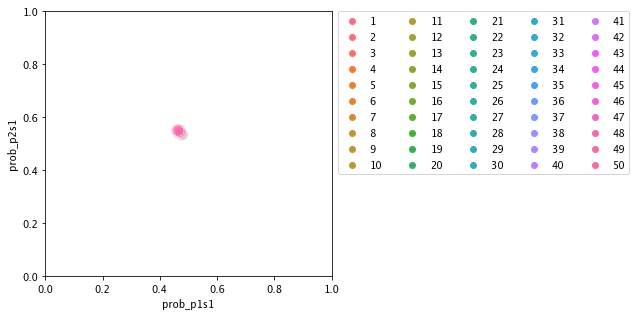

In [17]:
df_strategies = simulation_output[['sim_nr', 'round_nr', 'prob_p1s1', 'prob_p2s1']]
df_strategies = df_strategies.groupby(['sim_nr'],  as_index=False, sort=False).mean()
df_strategies['sim_nr'] = pd.Categorical(df_strategies['sim_nr'])
plt.figure(figsize=(9,4.5))
ax = sns.scatterplot(data=df_strategies, x="prob_p1s1", y="prob_p2s1", hue='sim_nr', s=130, alpha=0.5)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncol=5)
plt.tight_layout()

Density distribution of predicted equilibria across all simulation rounds

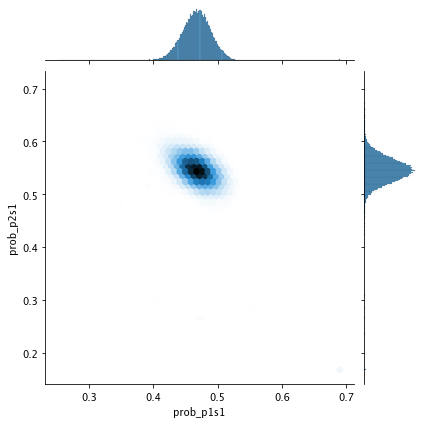

In [18]:
sns.jointplot(data=simulation_output, x='prob_p1s1', y='prob_p2s1', kind="hex")

Density distrubution of all predicted equilibria points, for all simulation rounds

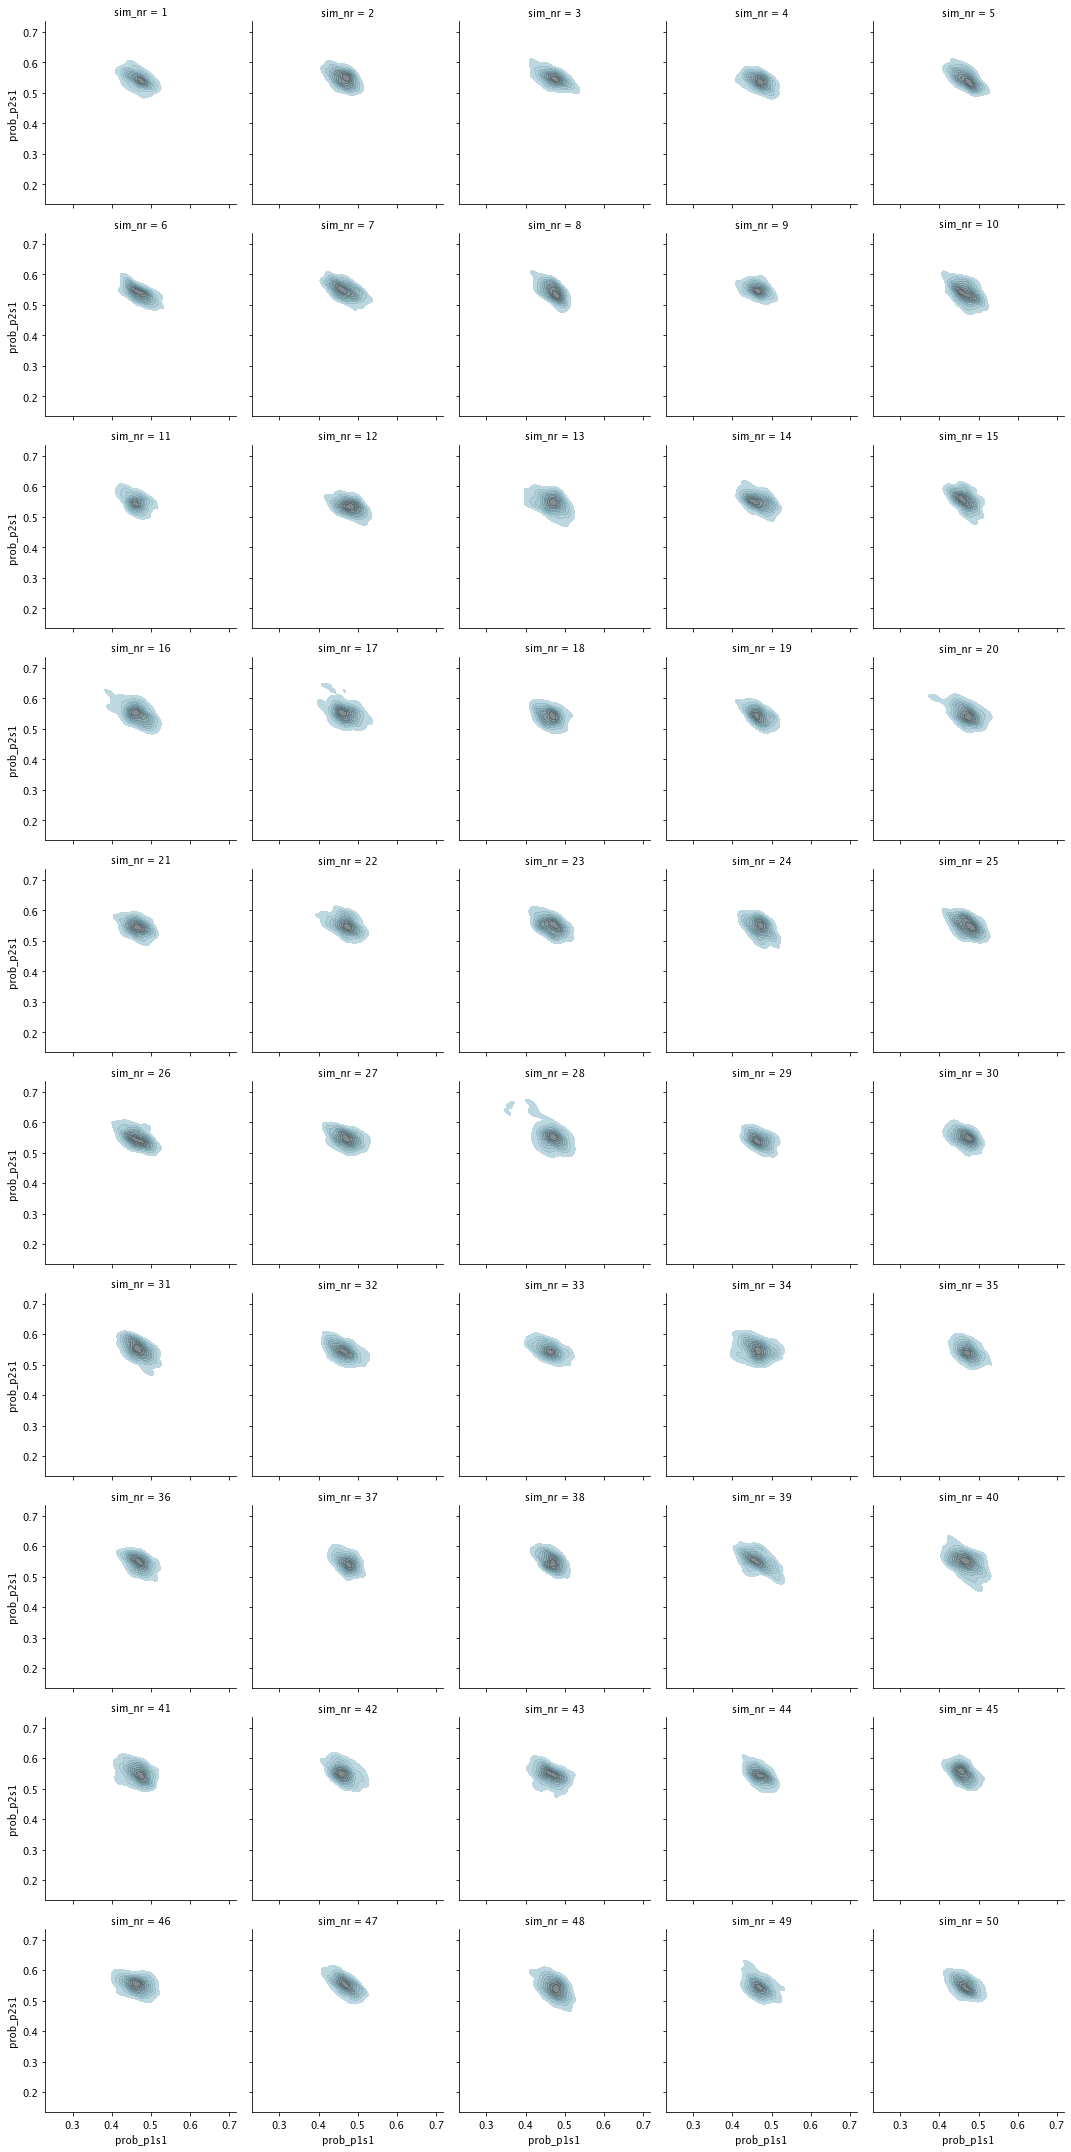

In [19]:
g = sns.FacetGrid(simulation_output, col = 'sim_nr', col_wrap=5)
g.map(sns.kdeplot, 'prob_p1s1', 'prob_p2s1', fill=True, color='lightblue', alpha=0.7)